# Left/Right stereotypy in Kenyon cells
Here we investigate whether the connections from projection neurons (PNs) to Kenyon
cells (KCs) have a "stereotyped" structure. By stereotyped, we mean whether there is
correlation in the edge structure between multiple samples of this subgraph. Here,
we compare the left and right subgraphs for a single larval *Drosophila* connectome
([Eichler et al. (2017)](https://www.nature.com/articles/nature23455)).

## Introduction
The general thinking in the field is that the connections from PNs to KCs are "random"
(though there are are some caveats and debates, see
[Zheng et al. (2020)](https://www.biorxiv.org/content/10.1101/2020.04.17.047167v2.abstract)).
The word "random" is doing a lot of work here, and I don't think the field would agree
to a distribution on that subgraph-as-a-random-variable that would satisfy us. The
general idea is that the PNs are stereotyped and identifiable across animals: I can
find the same one on each hemisphere of the brain, and across animals. Conversely, the
KCs are not, because there is not thought to be correlation between the edges projecting
from PNs to KCs. See the figure below for a schematic.

```{figure} ./images/mittal-fig-2a.png
---
width: 500px
name: mb-schematic
---
Schematic description of the mushroom body (here shown for the adult *Drosophila*,
the larva has far fewer neurons). Connections from projection neurons (PNs) to
Kenyon cells are thought to be random. Image from
[Mittal et al. (2020)](https://www.nature.com/articles/s41467-020-14836-6).
```

In [1]:

import datetime
import time
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from giskard.plot import histplot, matrixplot
from numba import njit
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import set_theme
from scipy.optimize import linear_sum_assignment
from tqdm.autonotebook import tqdm
import pickle
from pkg.data import load_andre_subgraph
from pkg.io import OUT_PATH

DISPLAY_FIGS = True

FILENAME = "kc_stereotypy"


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

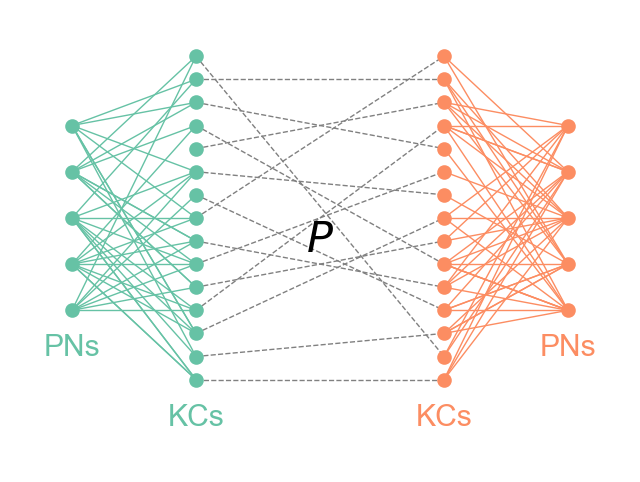

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

left_color = "#66c2a5"
right_color = "#fc8d62"
pn_left_start = (0.1, 0.75)
kc_left_start = (0.3, 0.9)
kc_right_start = (0.7, 0.9)
pn_right_start = (0.9, 0.75)
n_pn = 5
n_kc = 15


def draw_dots(start, n, gap, color):
    positions = []
    for i in range(n):
        pos = start[0], start[1] - i * gap
        ax.scatter(*pos, color=color)
        positions.append(pos)
    return positions


left_pn_pos = draw_dots(pn_left_start, n_pn, 0.1, left_color)
left_kc_pos = draw_dots(kc_left_start, n_kc, 0.05, left_color)
right_kc_pos = draw_dots(kc_right_start, n_kc, 0.05, right_color)
right_pn_pos = draw_dots(pn_right_start, n_pn, 0.1, right_color)


def draw_edges(p, k, pos1s, pos2s, color):
    for _, pos1 in enumerate(pos1s):
        edges = 0
        while edges < k:
            for _, pos2 in enumerate(pos2s):
                if rng.uniform() < p:
                    ax.plot(
                        (pos1[0], pos2[0]), (pos1[1], pos2[1]), color=color, linewidth=1
                    )
                    edges += 1


rng = np.random.default_rng(888888)
draw_edges(0.2, 7, left_pn_pos, left_kc_pos, left_color)
draw_edges(0.2, 7, right_pn_pos, right_kc_pos, right_color)

perm = rng.permutation(n_kc)
for i, target in enumerate(perm):
    pos1 = left_kc_pos[i]
    pos2 = right_kc_pos[target]
    ax.plot(
        (pos1[0], pos2[0]),
        (pos1[1], pos2[1]),
        color="grey",
        linewidth=1,
        zorder=-1,
        linestyle="--",
    )
fontsize = "large"
ax.text(pn_left_start[0], 0.25, "PNs", color=left_color, size=fontsize, ha="center")
ax.text(kc_left_start[0], 0.1, "KCs", color=left_color, size=fontsize, ha="center")
ax.text(pn_right_start[0], 0.25, "PNs", color=right_color, size=fontsize, ha="center")
ax.text(kc_right_start[0], 0.1, "KCs", color=right_color, size=fontsize, ha="center")
ax.text(0.5, 0.5, r"$P$", ha="center", va="center", fontsize="xx-large")
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.axis("off")
gluefig("diagram", fig)

## Load data

In [3]:

# NOTE: here just assuming the rows are sorted the same way

left_sub_df = load_andre_subgraph("left_lobe_connect", folder="from-andre-2022-10-16")
print((left_sub_df.shape))

right_sub_df = load_andre_subgraph("right_lobe_connect", folder="from-andre-2022-10-16")
print((right_sub_df.shape))

(21, 52)
(21, 50)


In [4]:

A_sub = right_sub_df.values
B_sub = left_sub_df.values

# A_pn_strength = np.sum(A_sub, axis=1)
# B_pn_strength = np.sum(B_sub, axis=1)

# A_node_data = pd.DataFrame(
#     data=A_pn_strength, columns=["strength"], index=left_sub_df.index
# ).reset_index()
# A_node_data["side"] = "Left"

# B_node_data = pd.DataFrame(
#     data=B_pn_strength, columns=["strength"], index=right_sub_df.index
# ).reset_index()
# B_node_data["side"] = "Right"

# node_data = pd.concat((A_node_data, B_node_data))
# sort_index = node_data.groupby("PN")["strength"].mean().sort_values().index[::-1]

# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# sns.barplot(data=node_data, x="PN", y="strength", hue="side", ax=ax, order=sort_index)
# sns.move_legend(
#     ax, loc="upper right", bbox_to_anchor=(1, 1), frameon=True, title="Side"
# )
# ax.set_ylabel("Node strength")

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# sns.scatterplot(
#     data=node_data.pivot(index="PN", values="strength", columns="side"),
#     x="Left",
#     y="Right",
#     ax=ax,
# )

## Graph matching
Using graph matching algorithms, it's easy to try to match the Kenyon cells on the
left and right hemispheres, here using only the connections from the PNs to the KCs.

```{note}
Because we are dealing with a bipartite subgraph for which we know the matching for
one of the parts, the graph matching problem reduces to a simple linear assignment
problem, meaning we can solve it very quickly and the solution is guaranteed to be
optimal (at least, according to the graph matching objective function, not
necessarily biology).
```

In [5]:


def match_seeded_subgraphs(A, B):
    """Assumes A is smaller"""
    # TODO it might be worth dealing with the case of ties using randomization in this
    # function, just to be safe.
    assert A.shape[0] == B.shape[0]
    assert A.shape[1] <= B.shape[1]
    product = A.T @ B
    row_inds, col_inds = linear_sum_assignment(product, maximize=True)
    assert (row_inds == np.arange(A.shape[1])).all()
    return col_inds[: A.shape[1]], B[:, col_inds]

In [6]:

perm, B_sub_perm = match_seeded_subgraphs(A_sub, B_sub)
ord = 2

## Evaluating the alignment
Given our estimated alignment of the KCs, we can evaluate the alignment by just
computing some measure of the difference between the two subgraphs. Here, I just
use the Frobenius norm of the difference (which turns out to be what graph matching
is optimizing for).

In [7]:
stat_observed = np.linalg.norm(A_sub - B_sub_perm, ord=ord)

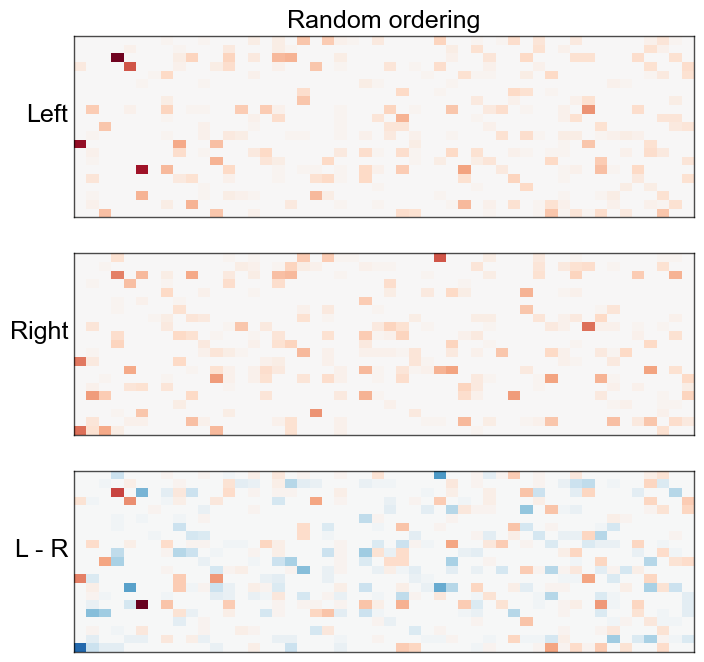

In [8]:


def plot_alignment(left, right, figsize=(8, 8)):
    diff = left - right
    fig, axs = plt.subplots(3, 1, figsize=figsize, sharex=True)

    matrixplot(left, cbar=False, ax=axs[0], vmax=40)
    matrixplot(right, cbar=False, ax=axs[1], vmax=40)
    matrixplot(diff, cbar=False, ax=axs[2])

    axs[0].set_ylabel("Left", rotation=0, ha="right")
    axs[1].set_ylabel("Right", rotation=0, ha="right")
    axs[2].set_ylabel("L - R", rotation=0, ha="right")

    fig.set_facecolor("w")

    return fig, axs


fig, axs = plot_alignment(A_sub, B_sub_perm)
axs[0].set_title("Random ordering")

gluefig("matched_subgraphs_weighted", fig)

## Comparing our edge disagreements to a null model

To calibrate our expectations for the alignment strength, we compute the alignment
strength for a series of network pairs sampled from a null model. In other words, we
sample two networks *which share no edge correlation*, match them, and compute the
alignment strength. This gives us a distribution of alignment strengths to compare
to.

```{note}
Need to add details of the null model here
```

In [9]:


@njit
def swap_edge(adjacency, edge_list):
    orig_inds = np.random.choice(len(edge_list), size=2, replace=False)

    # u -> v
    # x -> y
    u, v = edge_list[orig_inds[0]]
    x, y = edge_list[orig_inds[1]]

    # edge already exists, hold
    if adjacency[u, y] == 1 or adjacency[x, v] == 1:
        return adjacency, edge_list

    # no possibility of self-loops in this case

    # don't need to check reverse edge, since directed

    # perform the swap
    adjacency[u, v] = 0
    adjacency[x, y] = 0

    # u   v
    #   X
    # x   y
    adjacency[u, y] = 1
    adjacency[x, v] = 1

    # update edge list
    edge_list[orig_inds[0]] = [u, y]
    edge_list[orig_inds[1]] = [x, v]
    return adjacency, edge_list


def swap_edges(adjacency, n_swaps=1):
    adjacency = adjacency.copy()
    row_inds, col_inds = np.nonzero(adjacency)
    # TODO numba this for-loop?
    edge_list = np.array((row_inds, col_inds)).T
    for i in range(n_swaps):
        adjacency, edge_list = swap_edge(adjacency, edge_list)
    return adjacency


def apply_weights(adjacency, weights):
    row_inds, col_inds = np.nonzero(adjacency)
    weights = weights.copy()
    np.random.shuffle(weights)
    adjacency[row_inds, col_inds] = weights
    return adjacency


def generate_subgraph_samples(adjacency, n_samples=100, n_swaps=100000):
    adjacency = adjacency.copy()
    row_inds, col_inds = np.nonzero(adjacency)
    weights = adjacency[row_inds, col_inds].copy()
    adjacency[adjacency > 0] = 1

    samples = []
    for i in tqdm(range(n_samples)):
        adjacency = swap_edges(adjacency, n_swaps=n_swaps)
        adjacency = apply_weights(adjacency, weights)
        samples.append(adjacency.copy())

    return samples

Verify that the swap edges function works

```{note}
This uses an MCMC algorithm to sample from the null model, which has caveats.
```

In [10]:

test_A_sub = generate_subgraph_samples(A_sub, n_samples=1, n_swaps=10)[0]

# test that in and out degrees remain the same
assert (np.count_nonzero(test_A_sub, axis=0) == np.count_nonzero(A_sub, axis=0)).all()
assert (np.count_nonzero(test_A_sub, axis=1) == np.count_nonzero(A_sub, axis=1)).all()

# test that the weights are the same
test_weights = np.sort(test_A_sub[np.nonzero(test_A_sub)])
original_weights = np.sort(A_sub[np.nonzero(A_sub)])
assert (test_weights == original_weights).all()

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:


def save_samples(samples, name):
    with open(OUT_PATH / FILENAME / f"{name}.pkl", "wb") as f:
        pickle.dump(samples, f)


def load_samples(name):
    with open(OUT_PATH / FILENAME / f"{name}.pkl", "rb") as f:
        return pickle.load(f)


RERUN_SIMS = False
n_samples = 200  # number of total network samples
glue("n_samples", n_samples)
n_swaps = 100000  # swaps between each sample

if RERUN_SIMS:
    A_sub_samples = generate_subgraph_samples(
        A_sub, n_samples=n_samples, n_swaps=n_swaps
    )
    save_samples(A_sub_samples, "A_sub_samples")
    B_sub_samples = generate_subgraph_samples(
        B_sub, n_samples=n_samples, n_swaps=n_swaps
    )
    save_samples(B_sub_samples, "B_sub_samples")
else:
    A_sub_samples = load_samples("A_sub_samples")
    B_sub_samples = load_samples("B_sub_samples")


shuffle(B_sub_samples)

In [12]:
ord = 2
rows = []
for i in range(n_samples):
    A_sub_sim = A_sub_samples[i]
    B_sub_sim = B_sub_samples[i]
    perm_inds, B_sub_sim_perm = match_seeded_subgraphs(A_sub_sim, B_sub_sim)
    stat = np.linalg.norm(A_sub_sim - B_sub_sim_perm, ord=ord)
    rows.append({"data": "Random", "stat": stat})

perm, B_sub_perm = match_seeded_subgraphs(A_sub, B_sub)
stat_observed = np.linalg.norm(A_sub - B_sub_perm, ord=ord)
rows.append({"data": "Observed", "stat": stat_observed})
results = pd.DataFrame(rows)

Below we plot the PN (rows) to KC (columns) subgraphs under a permutation predicted
by seeded graph matching. We show the left subgraph (top), the right subgraph (middle),
and the difference (left - right) such that any red values indicate an edge on the left
which is not present in the right, and a blue value indicates an edge on the right
which is not in the right.

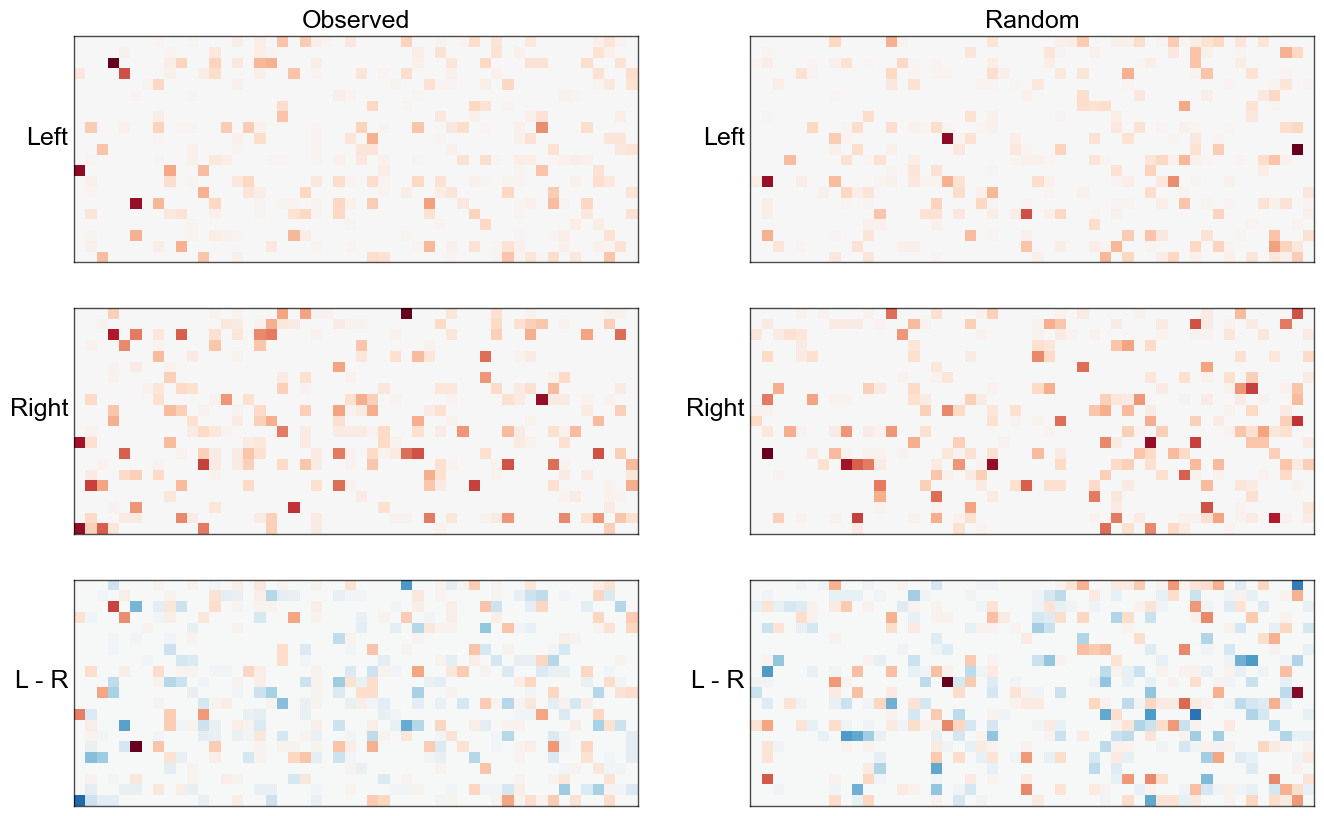

In [13]:
fig, main_axs = plt.subplots(3, 2, figsize=(16, 10))

axs = main_axs[:, 0]
left = A_sub
right = B_sub_perm

diff = left - right
matrixplot(left, cbar=False, ax=axs[0])
matrixplot(right, cbar=False, ax=axs[1])
matrixplot(diff, cbar=False, ax=axs[2])
axs[0].set_ylabel("Left", rotation=0, ha="right")
axs[1].set_ylabel("Right", rotation=0, ha="right")
axs[2].set_ylabel("L - R", rotation=0, ha="right")
axs[0].set_title("Observed")

axs = main_axs[:, 1]
left = A_sub_sim
right = B_sub_sim_perm

diff = left - right
matrixplot(left, cbar=False, ax=axs[0])
matrixplot(right, cbar=False, ax=axs[1])
matrixplot(diff, cbar=False, ax=axs[2])
axs[0].set_ylabel("Left", rotation=0, ha="right")
axs[1].set_ylabel("Right", rotation=0, ha="right")
axs[2].set_ylabel("L - R", rotation=0, ha="right")
axs[0].set_title("Random")

fig.set_facecolor("w")

## Evaluating the significance of the observed difference
Here, we plot the observed alignment of the left and right subgraphs, as well as those
observed from {glue:text}`n_samples` samples from the null model.

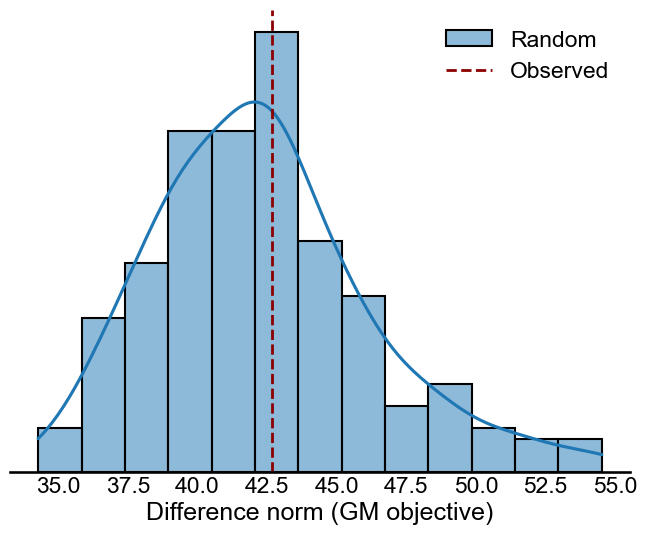

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
histplot(data=results, x="stat", hue="data", kde=True, ax=ax, side_legend=False)
ax.set(ylabel="", yticks=[], xlabel="Difference norm (GM objective)")
ax.spines["left"].set_visible(False)

gluefig("alignment_dist_weighted", fig)

## End

In [15]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:09.046686
Completed at 2023-02-13 09:45:06.411999
